# Notebook 3: Convolutional Autoencoder (CAE) Training

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** [Your Name]  
**Date:** 2025  

---

## 📋 Notebook Objectives

1. **Self-supervised pre-training** — Learn latent representations of tomato leaves
2. **Reconstruction learning** — Minimize MSE while maximizing structural fidelity
3. **Comprehensive metric tracking** — Loss, PSNR, SSIM per epoch with timing
4. **Best practices** — Early stopping, LR scheduling, checkpointing
5. **Scientific visualization** — Convergence curves, reconstruction quality

---

## 🔬 Scientific Rationale

The CAE learns to compress leaf images into a latent "spectral fingerprint" and reconstruct them.
This forces the encoder to capture:
- **Vein structures** — Critical for identifying vascular diseases
- **Texture patterns** — Distinguishes fungal spots from bacterial lesions
- **Color distributions** — Chlorophyll degradation signatures

The pre-trained encoder will be transferred to the classifier in Notebook 4.

---

## 1. Environment Setup & Configuration Loading

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm.notebook import tqdm

# Academic metrics
try:
    from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
except ImportError:
    print("Installing torchmetrics...")
    !pip install torchmetrics -q
    from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070 Ti Laptop GPU
Random seed: 42
Notebook executed at: 2026-01-26 13:07:55


In [2]:
# =============================================================================
# LOAD CONFIGURATION FROM NOTEBOOK 2
# =============================================================================

class ProjectPaths:
    """Centralized path management for the entire project."""
    
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    
    # Data paths
    DATA_RAW = ROOT / "data" / "raw"
    DATA_PROCESSED = ROOT / "data" / "processed"
    
    # Output paths
    NOTEBOOKS = ROOT / "notebooks"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CHECKPOINTS = ROOT / "checkpoints"
    LOGS = ROOT / "logs"
    CONFIG = ROOT / "config"

PATHS = ProjectPaths()

# Load split metadata from Notebook 2
metadata_path = PATHS.CONFIG / 'split_metadata.json'

if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        METADATA = json.load(f)
    print(f"✓ Metadata loaded from: {metadata_path}")
    
    # Extract key configuration
    NORM_MEAN = METADATA['normalization']['mean']
    NORM_STD = METADATA['normalization']['std']
    IMAGE_SIZE = METADATA['image_config']['size']
    NUM_CLASSES = METADATA['classes']['num_classes']
    CLASS_NAMES = METADATA['classes']['names_display']
    
    print(f"\n  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
    print(f"  Normalization mean: {[f'{m:.4f}' for m in NORM_MEAN]}")
    print(f"  Normalization std:  {[f'{s:.4f}' for s in NORM_STD]}")
    print(f"  Number of classes: {NUM_CLASSES}")
else:
    raise FileNotFoundError(
        f"Metadata not found at {metadata_path}. "
        "Please run Notebook 2 first."
    )

✓ Metadata loaded from: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/split_metadata.json

  Image size: 128×128
  Normalization mean: ['0.4504', '0.4662', '0.4011']
  Normalization std:  ['0.1742', '0.1514', '0.1907']
  Number of classes: 10


In [3]:
# =============================================================================
# TRAINING CONFIGURATION
# =============================================================================

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
CONFIG_CAE = {
    'batch_size': 64,
    'epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'patience': 7,              # Early stopping patience
    'lr_patience': 3,           # LR scheduler patience
    'lr_factor': 0.5,           # LR reduction factor
    'min_lr': 1e-6,             # Minimum learning rate
    'latent_channels': 128,     # Bottleneck channels
}

# Data paths
TRAIN_PATH = PATHS.DATA_PROCESSED / 'train'
VAL_PATH = PATHS.DATA_PROCESSED / 'val'

print("\n" + "="*60)
print("CAE TRAINING CONFIGURATION")
print("="*60)
print(f"Device:              {DEVICE}")
print(f"Batch size:          {CONFIG_CAE['batch_size']}")
print(f"Max epochs:          {CONFIG_CAE['epochs']}")
print(f"Learning rate:       {CONFIG_CAE['learning_rate']}")
print(f"Weight decay:        {CONFIG_CAE['weight_decay']}")
print(f"Early stop patience: {CONFIG_CAE['patience']}")
print(f"LR scheduler:        ReduceLROnPlateau (patience={CONFIG_CAE['lr_patience']}, factor={CONFIG_CAE['lr_factor']})")
print(f"Latent channels:     {CONFIG_CAE['latent_channels']}")
print(f"\nTrain path: {TRAIN_PATH}")
print(f"Val path:   {VAL_PATH}")


CAE TRAINING CONFIGURATION
Device:              cuda
Batch size:          64
Max epochs:          50
Learning rate:       0.001
Weight decay:        1e-05
Early stop patience: 7
LR scheduler:        ReduceLROnPlateau (patience=3, factor=0.5)
Latent channels:     128

Train path: /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/train
Val path:   /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/val


---

## 2. Data Pipeline

In [4]:
# =============================================================================
# DATA TRANSFORMS
# =============================================================================

# For CAE: We do NOT normalize (keep pixels in [0,1] for reconstruction)
# Normalization would make reconstruction targets harder to interpret
# We'll normalize only for the classifier in Notebook 4

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),  # Converts to [0, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG_CAE['batch_size'], 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG_CAE['batch_size'], 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\n✓ Training samples:   {len(train_dataset):,}")
print(f"✓ Validation samples: {len(val_dataset):,}")
print(f"✓ Training batches:   {len(train_loader):,}")
print(f"✓ Validation batches: {len(val_loader):,}")


✓ Training samples:   14,528
✓ Validation samples: 1,816
✓ Training batches:   227
✓ Validation batches: 29


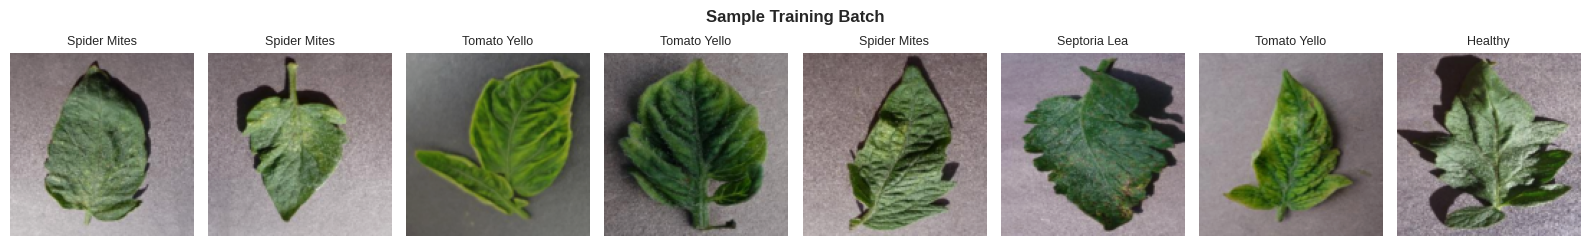

In [5]:
# =============================================================================
# VISUALIZE SAMPLE BATCH
# =============================================================================

def show_batch(loader, n_images=8):
    """Display a batch of images from the data loader."""
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2.5))
    
    for i in range(min(n_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(CLASS_NAMES[labels[i]][:12], fontsize=9)
    
    plt.suptitle('Sample Training Batch', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_batch(train_loader)

---

## 3. CAE Architecture

In [6]:
# =============================================================================
# CONVOLUTIONAL AUTOENCODER ARCHITECTURE
# =============================================================================

class ConvolutionalAutoencoder(nn.Module):
    """
    Convolutional Autoencoder for self-supervised feature learning.
    
    Architecture:
        Encoder: 3 Conv blocks (3→32→64→128) with stride-2 downsampling
        Bottleneck: 16×16×128 latent representation
        Decoder: 3 ConvTranspose blocks to reconstruct 128×128×3
    
    Input:  [B, 3, 128, 128]
    Latent: [B, 128, 16, 16]
    Output: [B, 3, 128, 128]
    """
    
    def __init__(self, latent_channels=128):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # Encoder: Compress spatial information into latent bottleneck
        self.encoder = nn.Sequential(
            # Block 1: 128×128×3 → 64×64×32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 2: 64×64×32 → 32×32×64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Block 3: 32×32×64 → 16×16×128
            nn.Conv2d(64, latent_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True),
        )
        
        # Decoder: Reconstruct from latent representation
        self.decoder = nn.Sequential(
            # Block 1: 16×16×128 → 32×32×64
            nn.ConvTranspose2d(latent_channels, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Block 2: 32×32×64 → 64×64×32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 3: 64×64×32 → 128×128×3
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1] to match input range
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def encode(self, x):
        """Encode input to latent representation."""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent representation to reconstruction."""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass: encode then decode."""
        z = self.encode(x)
        return self.decode(z)

# Instantiate model
model = ConvolutionalAutoencoder(latent_channels=CONFIG_CAE['latent_channels']).to(DEVICE)

# Print architecture summary
print("\n" + "="*60)
print("CAE ARCHITECTURE")
print("="*60)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
encoder_params = sum(p.numel() for p in model.encoder.parameters())
decoder_params = sum(p.numel() for p in model.decoder.parameters())

print("\n" + "-"*60)
print("PARAMETER COUNT")
print("-"*60)
print(f"Encoder parameters:  {encoder_params:,}")
print(f"Decoder parameters:  {decoder_params:,}")
print(f"Total parameters:    {total_params:,}")
print(f"Trainable:           {trainable_params:,}")


CAE ARCHITECTURE
ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(

In [7]:
# =============================================================================
# VERIFY ARCHITECTURE WITH DUMMY INPUT
# =============================================================================

# Test forward pass
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
dummy_latent = model.encode(dummy_input)
dummy_output = model(dummy_input)

print("\n" + "="*60)
print("ARCHITECTURE VERIFICATION")
print("="*60)
print(f"Input shape:   {list(dummy_input.shape)}")
print(f"Latent shape:  {list(dummy_latent.shape)}  ← Bottleneck (spectral fingerprint)")
print(f"Output shape:  {list(dummy_output.shape)}")
print(f"\nLatent dimensions: {dummy_latent.shape[1]} channels × {dummy_latent.shape[2]}×{dummy_latent.shape[3]} spatial")
print(f"Compression ratio: {(3*128*128) / (dummy_latent.shape[1]*dummy_latent.shape[2]*dummy_latent.shape[3]):.1f}x")


ARCHITECTURE VERIFICATION
Input shape:   [1, 3, 128, 128]
Latent shape:  [1, 128, 16, 16]  ← Bottleneck (spectral fingerprint)
Output shape:  [1, 3, 128, 128]

Latent dimensions: 128 channels × 16×16 spatial
Compression ratio: 1.5x


---

## 4. Training Setup

In [9]:
# =============================================================================
# LOSS, OPTIMIZER, SCHEDULER, METRICS
# =============================================================================

# Loss function: MSE for reconstruction
criterion = nn.MSELoss()

# Optimizer: Adam with weight decay
optimizer = optim.Adam(
    model.parameters(), 
    lr=CONFIG_CAE['learning_rate'],
    weight_decay=CONFIG_CAE['weight_decay']
)

# Learning rate scheduler: Reduce on plateau
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=CONFIG_CAE['lr_factor'],
    patience=CONFIG_CAE['lr_patience'],
    min_lr=CONFIG_CAE['min_lr']
)

# Initialize professional metrics
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

print("✓ Loss function: MSELoss")
print(f"✓ Optimizer: Adam (lr={CONFIG_CAE['learning_rate']}, weight_decay={CONFIG_CAE['weight_decay']})")
print(f"✓ Scheduler: ReduceLROnPlateau (patience={CONFIG_CAE['lr_patience']}, factor={CONFIG_CAE['lr_factor']})")
print("✓ Metrics: PSNR, SSIM (torchmetrics)")

✓ Loss function: MSELoss
✓ Optimizer: Adam (lr=0.001, weight_decay=1e-05)
✓ Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
✓ Metrics: PSNR, SSIM (torchmetrics)


In [10]:
# =============================================================================
# TRAINING HISTORY TRACKER
# =============================================================================

class TrainingHistory:
    """Track and store all training metrics."""
    
    def __init__(self):
        self.history = {
            'epoch': [],
            'train_loss': [],
            'val_loss': [],
            'psnr': [],
            'ssim': [],
            'learning_rate': [],
            'epoch_time': [],
        }
        self.best_val_loss = float('inf')
        self.best_psnr = 0
        self.best_ssim = 0
        self.best_epoch = 0
        self.total_time = 0
    
    def update(self, epoch, train_loss, val_loss, psnr, ssim, lr, epoch_time):
        """Update history with new epoch metrics."""
        self.history['epoch'].append(epoch)
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['psnr'].append(psnr)
        self.history['ssim'].append(ssim)
        self.history['learning_rate'].append(lr)
        self.history['epoch_time'].append(epoch_time)
        self.total_time += epoch_time
        
        # Track best metrics
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_epoch = epoch
        if psnr > self.best_psnr:
            self.best_psnr = psnr
        if ssim > self.best_ssim:
            self.best_ssim = ssim
    
    def get_dataframe(self):
        """Return history as pandas DataFrame."""
        return pd.DataFrame(self.history)
    
    def save(self, filepath):
        """Save history to CSV."""
        df = self.get_dataframe()
        df.to_csv(filepath, index=False)
        print(f"✓ Training history saved: {filepath}")

# Initialize history tracker
history = TrainingHistory()

---

## 5. Training Loop

In [11]:
# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    
    for images, _ in loader:
        images = images.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)


def validate_epoch(model, loader, criterion, psnr_metric, ssim_metric, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            
            # Compute metrics
            running_loss += criterion(outputs, images).item()
            running_psnr += psnr_metric(outputs, images).item()
            running_ssim += ssim_metric(outputs, images).item()
    
    n_batches = len(loader)
    return running_loss / n_batches, running_psnr / n_batches, running_ssim / n_batches

In [12]:
# =============================================================================
# MAIN TRAINING LOOP
# =============================================================================

print("\n" + "="*80)
print("STARTING CAE TRAINING")
print("="*80)
print(f"Device: {DEVICE}")
print(f"Epochs: {CONFIG_CAE['epochs']} (max)")
print(f"Early stopping patience: {CONFIG_CAE['patience']}")
print("="*80 + "\n")

# Early stopping variables
best_val_loss = float('inf')
early_stop_counter = 0
training_start_time = time.time()

# Checkpoint path
checkpoint_path = PATHS.CHECKPOINTS / 'cae_best.pth'
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, CONFIG_CAE['epochs'] + 1):
    epoch_start_time = time.time()
    
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validation
    val_loss, psnr, ssim = validate_epoch(
        model, val_loader, criterion, psnr_metric, ssim_metric, DEVICE
    )
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Update history
    history.update(epoch, train_loss, val_loss, psnr, ssim, current_lr, epoch_time)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Print epoch summary
    print(f"Epoch [{epoch:02d}/{CONFIG_CAE['epochs']}] "
          f"Train Loss: {train_loss:.5f} | "
          f"Val Loss: {val_loss:.5f} | "
          f"PSNR: {psnr:.2f} dB | "
          f"SSIM: {ssim:.4f} | "
          f"LR: {current_lr:.2e} | "
          f"Time: {epoch_time:.1f}s")
    
    # Checkpointing (save best model)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'psnr': psnr,
            'ssim': ssim,
            'config': CONFIG_CAE
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"  └─ ✓ Checkpoint saved (Val Loss: {val_loss:.5f})")
    else:
        early_stop_counter += 1
        print(f"  └─ No improvement ({early_stop_counter}/{CONFIG_CAE['patience']})")
        
        if early_stop_counter >= CONFIG_CAE['patience']:
            print(f"\n[INFO] Early stopping triggered at epoch {epoch}")
            break

# Training complete
total_training_time = time.time() - training_start_time

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Total epochs:        {epoch}")
print(f"Total training time: {timedelta(seconds=int(total_training_time))}")
print(f"Best epoch:          {history.best_epoch}")
print(f"Best val loss:       {history.best_val_loss:.5f}")
print(f"Best PSNR:           {history.best_psnr:.2f} dB")
print(f"Best SSIM:           {history.best_ssim:.4f}")
print(f"Checkpoint saved:    {checkpoint_path}")


STARTING CAE TRAINING
Device: cuda
Epochs: 50 (max)
Early stopping patience: 7

Epoch [01/50] Train Loss: 0.00456 | Val Loss: 0.00157 | PSNR: 28.19 dB | SSIM: 0.7451 | LR: 1.00e-03 | Time: 7.4s
  └─ ✓ Checkpoint saved (Val Loss: 0.00157)
Epoch [02/50] Train Loss: 0.00122 | Val Loss: 0.00113 | PSNR: 29.56 dB | SSIM: 0.8104 | LR: 1.00e-03 | Time: 7.0s
  └─ ✓ Checkpoint saved (Val Loss: 0.00113)
Epoch [03/50] Train Loss: 0.00092 | Val Loss: 0.00084 | PSNR: 30.92 dB | SSIM: 0.8330 | LR: 1.00e-03 | Time: 6.9s
  └─ ✓ Checkpoint saved (Val Loss: 0.00084)
Epoch [04/50] Train Loss: 0.00080 | Val Loss: 0.00099 | PSNR: 30.14 dB | SSIM: 0.8474 | LR: 1.00e-03 | Time: 6.6s
  └─ No improvement (1/7)
Epoch [05/50] Train Loss: 0.00074 | Val Loss: 0.00067 | PSNR: 31.83 dB | SSIM: 0.8832 | LR: 1.00e-03 | Time: 6.6s
  └─ ✓ Checkpoint saved (Val Loss: 0.00067)
Epoch [06/50] Train Loss: 0.00064 | Val Loss: 0.00060 | PSNR: 32.32 dB | SSIM: 0.8881 | LR: 1.00e-03 | Time: 6.8s
  └─ ✓ Checkpoint saved (Val Loss

---

## 6. Training Visualization

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_11_cae_training_curves.png


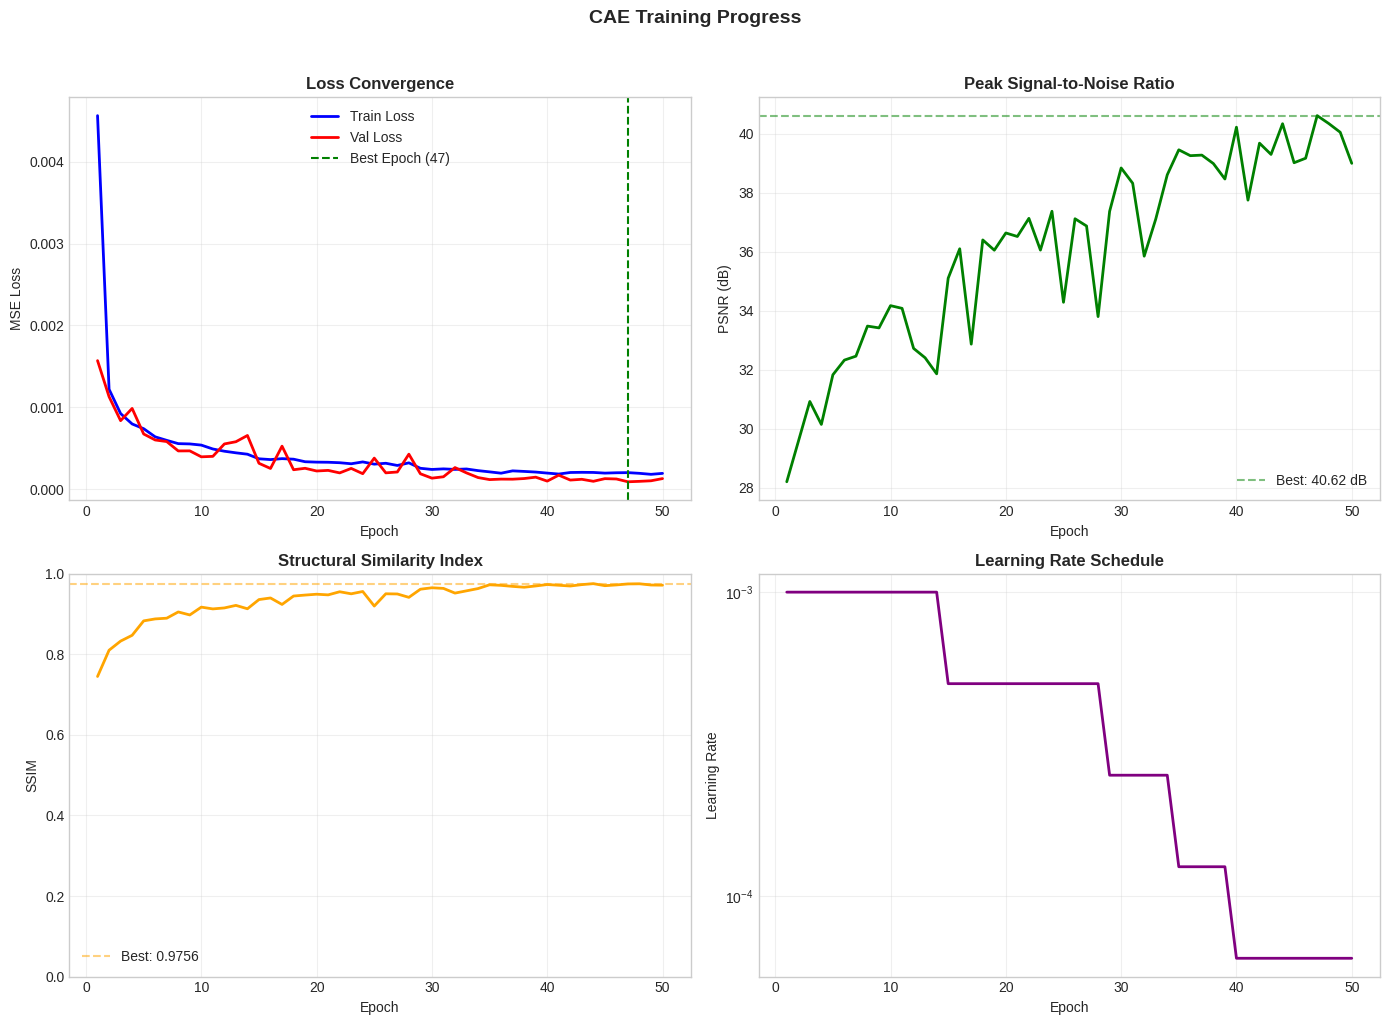

In [13]:
# =============================================================================
# PLOT TRAINING CURVES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = history.history['epoch']

# Plot 1: Loss Convergence
ax1 = axes[0, 0]
ax1.plot(epochs, history.history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.axvline(x=history.best_epoch, color='green', linestyle='--', label=f'Best Epoch ({history.best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Loss Convergence', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: PSNR (Signal Quality)
ax2 = axes[0, 1]
ax2.plot(epochs, history.history['psnr'], 'g-', linewidth=2)
ax2.axhline(y=history.best_psnr, color='green', linestyle='--', alpha=0.5, label=f'Best: {history.best_psnr:.2f} dB')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('PSNR (dB)')
ax2.set_title('Peak Signal-to-Noise Ratio', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: SSIM (Structural Similarity)
ax3 = axes[1, 0]
ax3.plot(epochs, history.history['ssim'], 'orange', linewidth=2)
ax3.axhline(y=history.best_ssim, color='orange', linestyle='--', alpha=0.5, label=f'Best: {history.best_ssim:.4f}')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('SSIM')
ax3.set_title('Structural Similarity Index', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Learning Rate
ax4 = axes[1, 1]
ax4.plot(epochs, history.history['learning_rate'], 'purple', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.suptitle('CAE Training Progress', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
fig_path = PATHS.OUTPUTS / 'fig_11_cae_training_curves.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

---

## 7. Reconstruction Quality Analysis

In [14]:
# =============================================================================
# LOAD BEST MODEL AND VISUALIZE RECONSTRUCTIONS
# =============================================================================

# Load best checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.5f}")
print(f"  PSNR: {checkpoint['psnr']:.2f} dB")
print(f"  SSIM: {checkpoint['ssim']:.4f}")

✓ Loaded best model from epoch 47
  Val Loss: 0.00009
  PSNR: 40.62 dB
  SSIM: 0.9749


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_12_cae_reconstructions.png


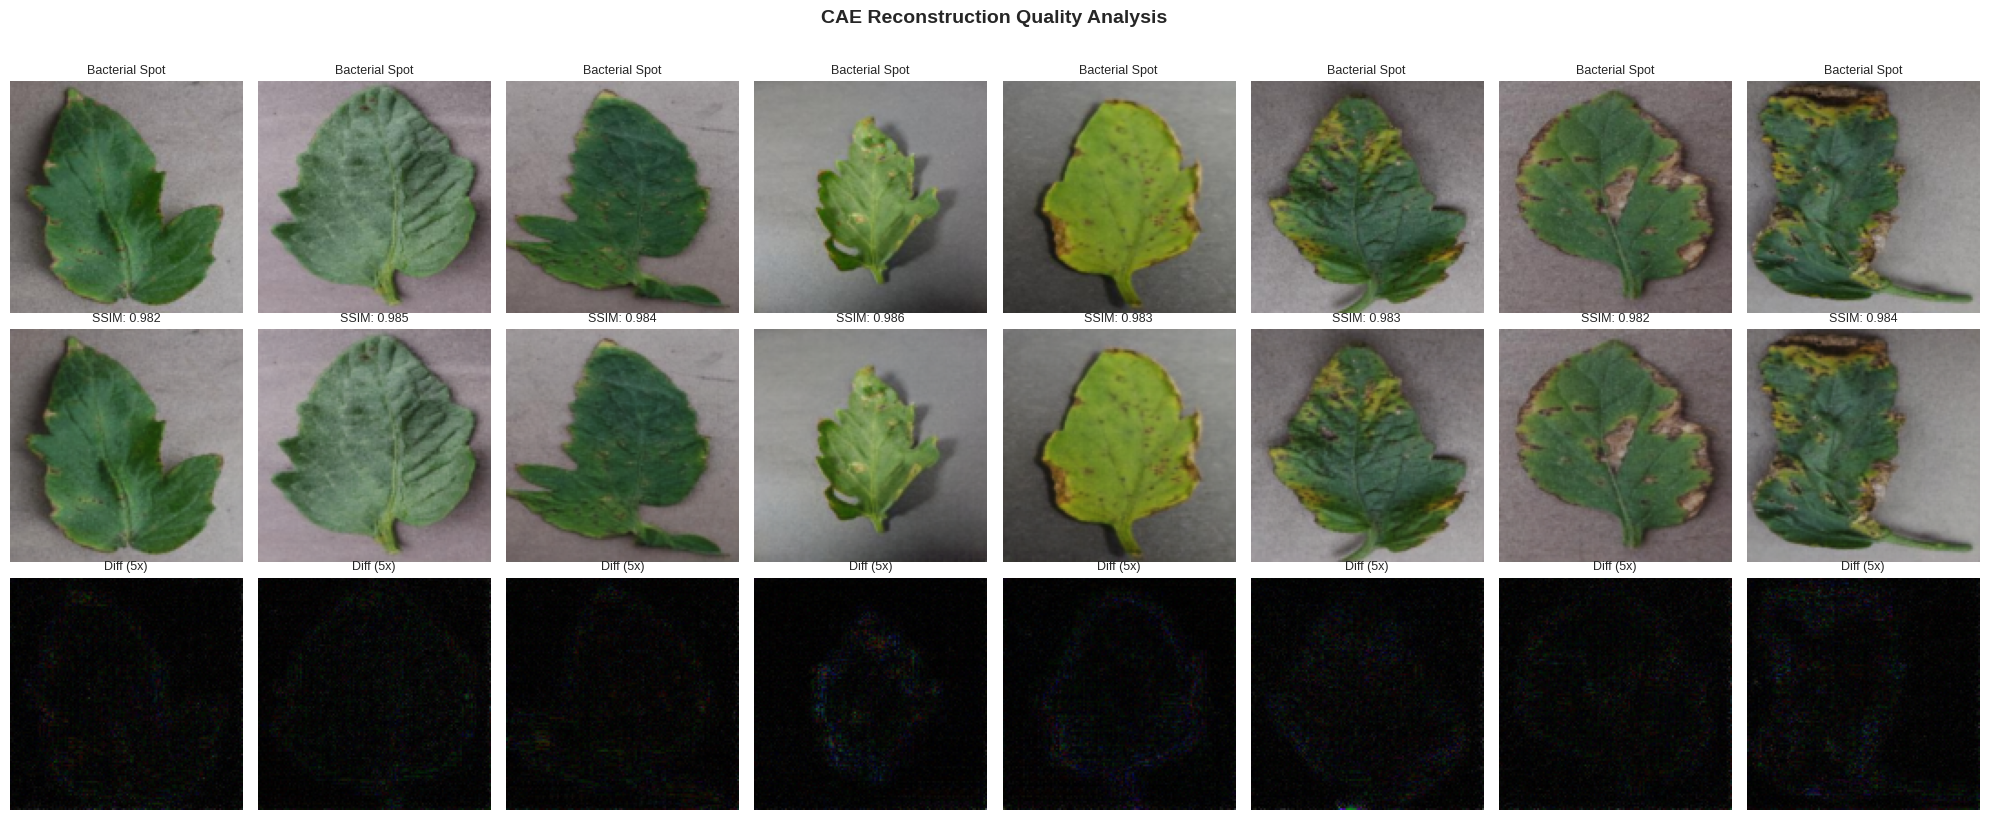

In [15]:
# =============================================================================
# VISUALIZE RECONSTRUCTIONS
# =============================================================================

def visualize_reconstructions(model, loader, class_names, n_samples=8, device=DEVICE):
    """
    Visualize original vs reconstructed images with per-image SSIM.
    """
    model.eval()
    
    # Get a batch
    images, labels = next(iter(loader))
    images = images.to(device)
    
    with torch.no_grad():
        reconstructions = model(images)
    
    # Move to CPU for visualization
    images_cpu = images.cpu()
    recon_cpu = reconstructions.cpu()
    
    # Create figure
    fig, axes = plt.subplots(3, n_samples, figsize=(n_samples * 2.5, 8))
    
    for i in range(min(n_samples, len(images))):
        # Original
        orig_img = images_cpu[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(class_names[labels[i]][:15], fontsize=9)
        axes[0, i].axis('off')
        
        # Reconstructed
        recon_img = recon_cpu[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(recon_img)
        
        # Compute per-image SSIM
        with torch.no_grad():
            img_ssim = ssim_metric(
                reconstructions[i:i+1], 
                images[i:i+1]
            ).item()
        axes[1, i].set_title(f'SSIM: {img_ssim:.3f}', fontsize=9)
        axes[1, i].axis('off')
        
        # Difference (amplified)
        diff = np.abs(orig_img - recon_img)
        diff_amplified = np.clip(diff * 5, 0, 1)  # Amplify for visibility
        axes[2, i].imshow(diff_amplified)
        axes[2, i].set_title('Diff (5x)', fontsize=9)
        axes[2, i].axis('off')
    
    # Row labels
    axes[0, 0].set_ylabel('Original', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Reconstructed', fontsize=11, fontweight='bold')
    axes[2, 0].set_ylabel('Difference', fontsize=11, fontweight='bold')
    
    plt.suptitle('CAE Reconstruction Quality Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_12_cae_reconstructions.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Visualize
visualize_reconstructions(model, val_loader, CLASS_NAMES, n_samples=8)

In [16]:
# =============================================================================
# RECONSTRUCTION QUALITY BY CLASS
# =============================================================================

def compute_class_reconstruction_quality(model, loader, class_names, device=DEVICE):
    """
    Compute average reconstruction metrics per class.
    """
    model.eval()
    
    class_ssim = {name: [] for name in class_names}
    class_psnr = {name: [] for name in class_names}
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Computing class metrics"):
            images = images.to(device)
            reconstructions = model(images)
            
            for i in range(len(images)):
                class_name = class_names[labels[i]]
                
                # Per-image metrics
                ssim_val = ssim_metric(reconstructions[i:i+1], images[i:i+1]).item()
                psnr_val = psnr_metric(reconstructions[i:i+1], images[i:i+1]).item()
                
                class_ssim[class_name].append(ssim_val)
                class_psnr[class_name].append(psnr_val)
    
    # Compute averages
    results = []
    for name in class_names:
        results.append({
            'class': name,
            'avg_ssim': np.mean(class_ssim[name]),
            'std_ssim': np.std(class_ssim[name]),
            'avg_psnr': np.mean(class_psnr[name]),
            'std_psnr': np.std(class_psnr[name]),
            'n_samples': len(class_ssim[name])
        })
    
    return pd.DataFrame(results)

# Compute per-class metrics
class_metrics = compute_class_reconstruction_quality(model, val_loader, CLASS_NAMES)

print("\n" + "="*80)
print("RECONSTRUCTION QUALITY BY CLASS")
print("="*80)
print(class_metrics.to_string(index=False))

Computing class metrics:   0%|          | 0/29 [00:00<?, ?it/s]


RECONSTRUCTION QUALITY BY CLASS
                               class  avg_ssim  std_ssim  avg_psnr  std_psnr  n_samples
                      Bacterial Spot  0.983636  0.002125 42.971778  1.055354        213
                        Early Blight  0.982075  0.002833 40.696228  1.546849        100
                         Late Blight  0.930887  0.148279 40.700950  3.122884        191
                           Leaf Mold  0.975628  0.007924 40.666743  1.644077         96
                  Septoria Leaf Spot  0.976247  0.003209 39.922973  1.445908        177
Spider Mites Two-Spotted Spider Mite  0.979107  0.002539 40.550398  1.238637        167
                         Target Spot  0.980730  0.002225 40.067903  1.086656        140
       Tomato Yellow Leaf Curl Virus  0.981582  0.003927 41.501161  1.370485        535
                 Tomato Mosaic Virus  0.978033  0.001690 40.465746  0.540141         38
                             Healthy  0.976652  0.002481 39.883460  2.444105        159

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_13_cae_class_metrics.png


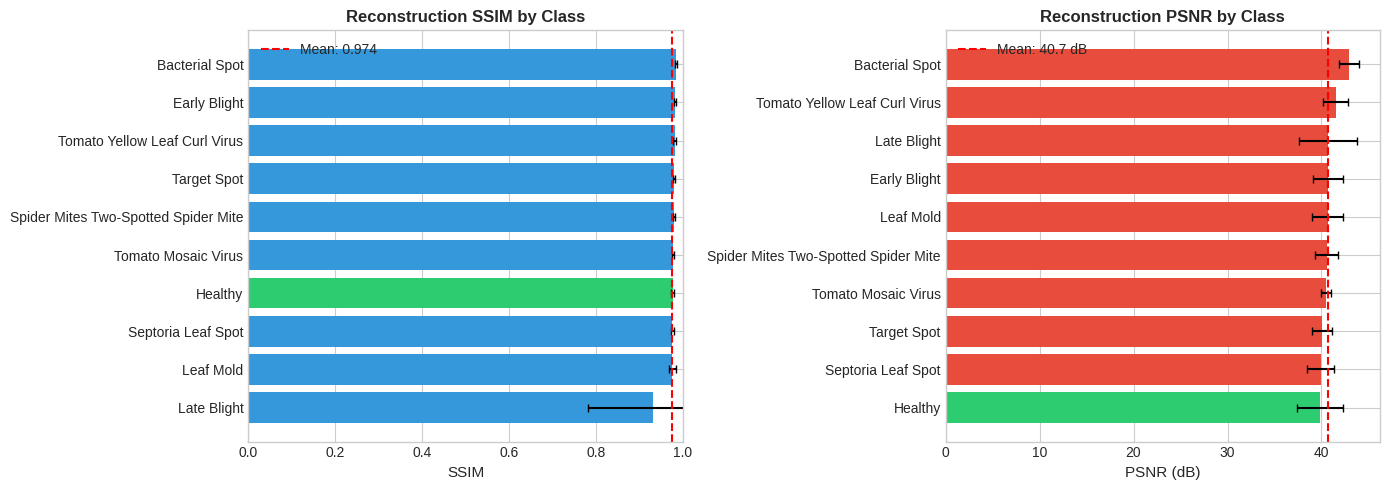

In [17]:
# =============================================================================
# VISUALIZE CLASS-WISE METRICS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by SSIM
class_metrics_sorted = class_metrics.sort_values('avg_ssim', ascending=True)

# Plot 1: SSIM by class
ax1 = axes[0]
colors = ['#2ecc71' if 'Healthy' in name else '#3498db' for name in class_metrics_sorted['class']]
bars1 = ax1.barh(class_metrics_sorted['class'], class_metrics_sorted['avg_ssim'], 
                 xerr=class_metrics_sorted['std_ssim'], color=colors, capsize=3)
ax1.set_xlabel('SSIM', fontsize=11)
ax1.set_title('Reconstruction SSIM by Class', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.axvline(x=class_metrics['avg_ssim'].mean(), color='red', linestyle='--', 
            label=f'Mean: {class_metrics["avg_ssim"].mean():.3f}')
ax1.legend()

# Plot 2: PSNR by class
ax2 = axes[1]
class_metrics_sorted_psnr = class_metrics.sort_values('avg_psnr', ascending=True)
colors2 = ['#2ecc71' if 'Healthy' in name else '#e74c3c' for name in class_metrics_sorted_psnr['class']]
bars2 = ax2.barh(class_metrics_sorted_psnr['class'], class_metrics_sorted_psnr['avg_psnr'], 
                 xerr=class_metrics_sorted_psnr['std_psnr'], color=colors2, capsize=3)
ax2.set_xlabel('PSNR (dB)', fontsize=11)
ax2.set_title('Reconstruction PSNR by Class', fontsize=12, fontweight='bold')
ax2.axvline(x=class_metrics['avg_psnr'].mean(), color='red', linestyle='--', 
            label=f'Mean: {class_metrics["avg_psnr"].mean():.1f} dB')
ax2.legend()

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_13_cae_class_metrics.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

---

## 8. Save Final Model & Export

In [18]:
# =============================================================================
# SAVE ENCODER FOR CLASSIFIER (NOTEBOOK 4)
# =============================================================================

# Save just the encoder weights for transfer learning
encoder_path = PATHS.MODELS / 'cae_encoder.pth'
encoder_path.parent.mkdir(parents=True, exist_ok=True)

torch.save({
    'encoder_state_dict': model.encoder.state_dict(),
    'latent_channels': CONFIG_CAE['latent_channels'],
    'image_size': IMAGE_SIZE,
    'best_ssim': history.best_ssim,
    'best_psnr': history.best_psnr,
    'training_epochs': len(history.history['epoch'])
}, encoder_path)

print(f"✓ Encoder saved: {encoder_path}")

# Save full model for reconstruction tasks
full_model_path = PATHS.MODELS / 'cae_full.pth'
torch.save(model.state_dict(), full_model_path)
print(f"✓ Full CAE saved: {full_model_path}")

✓ Encoder saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/cae_encoder.pth
✓ Full CAE saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/cae_full.pth


In [19]:
# =============================================================================
# SAVE TRAINING HISTORY
# =============================================================================

# Save as CSV
history_path = PATHS.LOGS / 'cae_training_history.csv'
history_path.parent.mkdir(parents=True, exist_ok=True)
history.save(history_path)

# Save training summary as JSON
training_summary = {
    'completed_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_epochs': len(history.history['epoch']),
    'total_training_time_seconds': history.total_time,
    'total_training_time_formatted': str(timedelta(seconds=int(history.total_time))),
    'best_epoch': history.best_epoch,
    'best_val_loss': history.best_val_loss,
    'best_psnr': history.best_psnr,
    'best_ssim': history.best_ssim,
    'final_learning_rate': history.history['learning_rate'][-1],
    'config': CONFIG_CAE,
    'model_paths': {
        'encoder': str(encoder_path),
        'full_model': str(full_model_path),
        'checkpoint': str(checkpoint_path)
    }
}

summary_path = PATHS.CONFIG / 'cae_training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"✓ Training summary saved: {summary_path}")

# Display summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(json.dumps(training_summary, indent=2))

✓ Training history saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/logs/cae_training_history.csv
✓ Training summary saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/cae_training_summary.json

TRAINING SUMMARY
{
  "completed_date": "2026-01-26 13:05:02",
  "total_epochs": 50,
  "total_training_time_seconds": 343.4137010574341,
  "total_training_time_formatted": "0:05:43",
  "best_epoch": 47,
  "best_val_loss": 8.912151528859576e-05,
  "best_psnr": 40.62061086194269,
  "best_ssim": 0.9756451475209204,
  "final_learning_rate": 6.25e-05,
  "config": {
    "batch_size": 64,
    "epochs": 50,
    "learning_rate": 0.001,
    "weight_decay": 1e-05,
    "patience": 7,
    "lr_patience": 3,
    "lr_factor": 0.5,
    "min_lr": 1e-06,
    "latent_channels": 128
  },
  "model_paths": {
    "encoder": "/home/maliciit/ml-projects/python-projects/plant-village-cae/models/cae_encoder.pth",
    "full_model": "/home/maliciit/ml-projects/python-projects/plant-

---

## 9. Summary & Next Steps

### ✅ Completed in This Notebook

1. **CAE architecture** — 3-block encoder/decoder with 128-channel bottleneck
2. **Self-supervised training** — Reconstruction loss minimization
3. **Metric tracking** — Loss, PSNR, SSIM, LR, time per epoch
4. **Best practices** — Early stopping, LR scheduling, checkpointing
5. **Quality analysis** — Per-class reconstruction metrics
6. **Export** — Encoder weights for transfer learning

### 📊 Key Results

| Metric | Value |
|--------|-------|
| Best Epoch | See summary above |
| Best PSNR | See summary above |
| Best SSIM | See summary above |
| Training Time | See summary above |

### 📁 Files Created

- `models/cae_encoder.pth` — Encoder weights for classifier
- `models/cae_full.pth` — Full CAE model
- `checkpoints/cae_best.pth` — Best checkpoint with optimizer state
- `logs/cae_training_history.csv` — Epoch-by-epoch metrics
- `config/cae_training_summary.json` — Training configuration & results

### ➡️ Next Notebook: `4_CNN_Classifier_Training.ipynb`

- Load pre-trained encoder
- Add classification head
- Fine-tune on disease classification
- Track F1, Precision, Recall

In [3]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*60)
print("✓ NOTEBOOK 3 COMPLETE")
print("="*60)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nGenerated figures: {PATHS.OUTPUTS}")
print(f"Model saved: {PATHS.MODELS}")
print(f"Training logs: {PATHS.LOGS}")
print("\nProceed to: 4_CNN_Classifier_Training.ipynb")


✓ NOTEBOOK 3 COMPLETE
Execution finished at: 2026-01-26 13:08:01


NameError: name 'PATHS' is not defined